# Weather data aggregation for the Finnish detached housing stock.

In this example, we'll aggregate ERA5 weather data for the Finnish building
stock based on national population density statistics for the purposes
of simple lumped-capacitance building thermal modelling of building stock
heat demand.
Unlike when calculating PV or wind power production or degree-day heat demand,
we're not interested in the *accumulated* weather, but instead on the *average*
weather over the desired geographical distribution.
The weather data parameters we're interested in are:

1. Ambient temperature.
2. Direct solar irradiation for vertical surfaces facing the cardinal directions.
3. Diffuse solar irradiation for vertical surfaces facing the cardinal directions.

This example borrows heavily from the previous examples for
[creating a cutout](https://atlite.readthedocs.io/en/latest/examples/create_cutout.html)
and [historic PV and wind comparison](https://atlite.readthedocs.io/en/latest/examples/historic-comparison-germany.html),
so familiarizing oneself with them might help with following this one.

## Import necessary packages

As usual, we'll need to start by importing the necessary packages.

In [1]:
import atlite
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

## Defining the Finland cutout from ERA5

Here, we'll define the `cutout` serving as the basis for our calculations.
For the purposes of this example, we'll be using ERA5 data for Finland for
the year 2011.
We're using a GeoDataFrame for determining the bounding box for Finland.
*(And later for clipping the population density data)*

In [2]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
finland = world.loc[world.iso_a3 == 'FIN']
x1, y1, x2, y2 = finland.bounds.values[0]

In [3]:
cutout = atlite.Cutout(
    path="finland-2011_gdf.nc",
    module="era5",
    x=slice(x1-.2,x2+.2),
    y=slice(y1-.2,y2+.2),
    time="2011-01"
)

c:\data\atlite\atlite\cutout.py:186: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


# Preparing the cutout

**This is where the work happens, and preparing the cutout can take long time
depending on your machine and your internet connection when downloading the
required data.**
While techically wind speeds affects building heat demand,
simplified models often replace this interaction with some constant
approximation.
Thus, we're only interested in temperature data for heat losses,
and solar irradiation data for solar heat gains.

In [4]:
cutout.prepare(features=['influx', 'temperature'])

INFO:atlite.data:Storing temporary files in C:\Users\TRTOPI\AppData\Local\Temp\tmpxfd2ze4m


<Cutout "finland-2011_gdf">
 x = 20.50 ⟷ 31.50, dx = 0.25
 y = 59.75 ⟷ 70.25, dy = 0.25
 time = 2011-01-01 ⟷ 2011-01-31, dt = H
 module = era5
 prepared_features = ['influx', 'temperature']

## Generating the layout

For the population density data, we'll use data from the
[European Environment Agency based on Corine Land Cover 2000](https://www.eea.europa.eu/data-and-maps/data/population-density-disaggregated-with-corine-land-cover-2000-2).
Here's a link to the actual [GeoTiff file](https://www.eea.europa.eu/ds_resolveuid/9TBGV2SUIW).
For reading the GeoTiff into a layout `xarray.DataArray`, we'll use the
[rioxarray package](https://pypi.org/project/rioxarray/).
Furthermore, since the GeoTiff covers the entirety of Europe, we'll use the
`GeoDataFrame` for Finland to clip the raster.

In [5]:
import rioxarray
population_density = rioxarray.open_rasterio("popu01clcv5.tif", masked=True)

Now, the `popu01clcv5.tif` covers the entirety of Europe, which is too large
for our purposes. Thus, we want to clip it to cover only Finland.
However, the population density data uses EPSG:3035 ETRS89/ETRS-LAEA
as its coordinate reference system:

In [6]:
population_density.rio.crs

CRS.from_wkt('PROJCS["ETRS_1989_LAEA_L52_M10",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

whereas the ERA5 data and our Finland GeoDataFrame use EPSG:4326

In [7]:
finland.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Thus, we need to do some reprojections.
Since the `popu01clcv5.tif` is quite large, it's actually faster to reproject
the Finland GeoDataFrame to EPSG:3035 first, then clip the raster,
and project the clipped raster to EPSG:4326, than to reproject
the entire raster and then clip it.

*(Plotting the raster for Finland takes a few minutes, because the population density data has a ludicurous resolution of 100x100m)*

*(The `from_disk=True` preserves memory, as otherwise dealing with the massive raster can result in running out of RAM)*

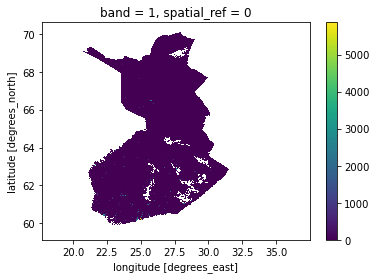

In [8]:
# Reproject Finland GeoDataFrame to EPSG:3035
finland_3035 = finland.to_crs("EPSG:3035")

# Clip the raster data and reproject the result back into EPSG:4326,
# also remove some unnecessary dimensions via `squeeze()`
finland_population_density = population_density.rio.clip(
    finland_3035.geometry, from_disk=True
).rio.reproject("EPSG:4326", from_disk=True).squeeze()

finland_population_density.plot()

The layout made based on the population density data has an unnecessarily
high resolution for our purposes.
In order to proceed, we need to match the layout to the cutout indicex.

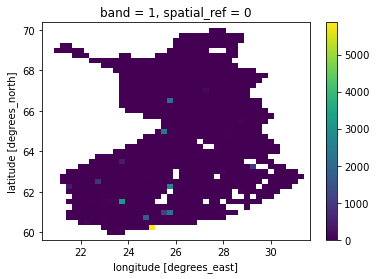

In [30]:
downscaled = finland_population_density.reindex_like(
    cutout.data, method='nearest'
)
downscaled.plot()

Much better.
Finally, since we're interested in the *average* weather instead of *accumulated*
weather, we need to normalize the above raster data to form the final layout.
For comparison, we'll also create a uniformly distributed layout.

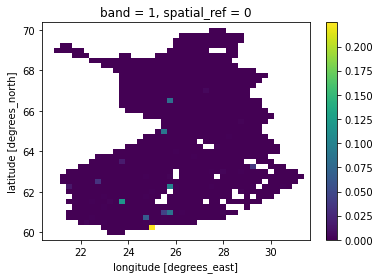

In [31]:
layout = downscaled / downscaled.sum()
layout.plot()

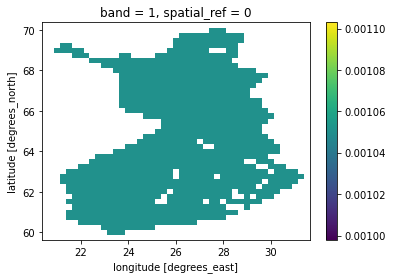

In [32]:
uniform = layout.round() + 1.
uniform = uniform / uniform.sum()
uniform.plot()

In addition to the population density weighed temperature and the uniformly
distributed temperature, we'll also want to fetch the temperature for the city
of *Jyväskylä*, as its heating degree days are used by Statistics Finland for
estimating the heating demand of the Finnish residential building stock.

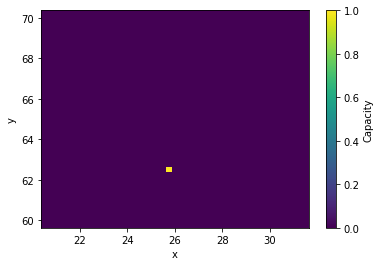

In [33]:
import pandas as pd
jyvaskyla = cutout.layout_from_capacity_list(
    pd.DataFrame(data={'x':[25.68], 'y':[62.40], 'Capacity':1.})
)
jyvaskyla.plot()

## Calculating the average weather

Now that we have our layouts ready, we can simply pass them to the `cutout`
to get the weather data we need.

INFO:atlite.convert:Convert and aggregate 'temperature'.
INFO:atlite.convert:Convert and aggregate 'temperature'.
INFO:atlite.convert:Convert and aggregate 'temperature'.


<AxesSubplot:xlabel='time'>

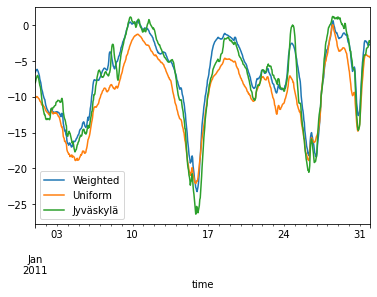

In [39]:
# Define figure size for plotting
fsize = (25,6)

# Collect temperature data into a dictionary
temperature_dict = {}
layouts = {'Weighted':layout, 'Uniform':uniform, 'Jyväskylä':jyvaskyla}

for name, lout in layouts.items():
    temperature_dict[name] = cutout.temperature(layout=lout.fillna(0.))\
        .squeeze().to_series()


# Convert dictionary to dataframe for easier plotting.
temps = pd.DataFrame(temperature_dict)
temps.plot(figsize = fsize)
plt.title("Ambient temperature comparison")
plt.ylabel("Ambient temperature [C]")
plt.xlabel("Datetime")

AttributeError: 'dict' object has no attribute 'plot'